In [2]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch_pruning as tp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Though not used for CMaps chronological split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import time
import copy
import pickle # For saving/loading history

# Type Hinting
from typing import Tuple, List, Dict, Union, Optional

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 4090


# Cell 2: IntermediateBlock Definition (Helper for LSTM)

In [3]:
class IntermediateBlock(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.2):
        """
        A block consisting of a Linear layer, ReLU activation, and Dropout.
        """
        super(IntermediateBlock, self).__init__()
        self.fc = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

# Cell 3: LSTM Model Definition (Using IntermediateBlocks)

In [4]:
class TimeSeriesLSTM_WithBlocks(nn.Module):
    def __init__(self, input_size: int, lstm_hidden_size: int, num_lstm_layers: int,
                 block_configs: List[int], # List of output sizes for each intermediate block
                 output_size: int = 1,
                 lstm_dropout_prob: float = 0.0, # Dropout for LSTM layers if num_layers > 1
                 block_dropout_prob: float = 0.2, # Dropout within each IntermediateBlock
                 bidirectional_lstm: bool = False
                ):
        super(TimeSeriesLSTM_WithBlocks, self).__init__()
        self.model_type = 'LSTM_WithBlocks'
        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size
        self.num_lstm_layers = num_lstm_layers
        self.output_size = output_size
        self.bidirectional_lstm = bidirectional_lstm
        num_directions = 2 if bidirectional_lstm else 1

        self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers,
                            batch_first=True,
                            dropout=lstm_dropout_prob if num_lstm_layers > 1 else 0,
                            bidirectional=bidirectional_lstm)

        self.intermediate_blocks = nn.ModuleList()
        current_in_features = lstm_hidden_size * num_directions # Output of LSTM

        for block_out_features in block_configs:
            self.intermediate_blocks.append(
                IntermediateBlock(current_in_features, block_out_features, block_dropout_prob)
            )
            current_in_features = block_out_features

        self.fc_final = nn.Linear(current_in_features, output_size)
        self.init_weights()

    def init_weights(self) -> None:
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name: nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name: nn.init.orthogonal_(param.data)
            elif 'bias' in name: param.data.fill_(0)
        for block in self.intermediate_blocks:
            if hasattr(block, 'fc') and isinstance(block.fc, nn.Linear):
                 nn.init.kaiming_uniform_(block.fc.weight, nonlinearity='relu')
                 if block.fc.bias is not None: nn.init.constant_(block.fc.bias, 0)
        if hasattr(self, 'fc_final') and isinstance(self.fc_final, nn.Linear):
             nn.init.kaiming_uniform_(self.fc_final.weight, nonlinearity='relu') # Or xavier for final linear
             if self.fc_final.bias is not None: nn.init.constant_(self.fc_final.bias, 0)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        num_directions = 2 if self.bidirectional_lstm else 1
        h0 = torch.zeros(self.num_lstm_layers * num_directions, batch_size, self.lstm_hidden_size).to(x.device)
        c0 = torch.zeros(self.num_lstm_layers * num_directions, batch_size, self.lstm_hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h0,c0))
        # lstm_out is (batch, seq_len, hidden_size * num_directions)
        # We typically take the output of the last time step
        processed_lstm_out = lstm_out[:, -1, :]

        # Pass through intermediate blocks
        intermediate_out = processed_lstm_out
        for block in self.intermediate_blocks:
            intermediate_out = block(intermediate_out)

        final_out = self.fc_final(intermediate_out)
        return final_out

    def get_prunable_layers(self) -> List[nn.Linear]:
        """Returns a list of Linear layers within intermediate blocks and the final FC layer."""
        prunable = []
        if hasattr(self, 'intermediate_blocks'):
            for block in self.intermediate_blocks:
                if isinstance(block, IntermediateBlock) and hasattr(block, 'fc'):
                    prunable.append(block.fc)
        if hasattr(self, 'fc_final') and isinstance(self.fc_final, nn.Linear):
            prunable.append(self.fc_final)
        return prunable

# Cell 4: NASA CMaps Data Handling Functions

In [5]:
# --- CMaps Data Constants ---
CMAPS_COLUMN_NAMES = ['unit_number', 'time_in_cycles'] + \
                     [f'op_setting_{i}' for i in range(1, 4)] + \
                     [f'sensor_{i}' for i in range(1, 22)] # FD001 has 21 sensors typically loaded

# --- CMaps Loading and Basic Preprocessing ---
def load_cmapss_dataframe(file_path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path, sep=' ', header=None, usecols=range(len(CMAPS_COLUMN_NAMES))) # Limit columns
        df.columns = CMAPS_COLUMN_NAMES
        df.dropna(axis=1, how='all', inplace=True) # Drop fully empty columns if any due to parsing
        return df
    except Exception as e:
        print(f"Error loading CMaps file {file_path}: {e}")
        return None

def add_cmapss_rul(df: pd.DataFrame, clip_at: int = 125) -> pd.DataFrame:
    if df is None: return None
    max_cycles = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycles.columns = ['unit_number', 'max_cycle']
    df = df.merge(max_cycles, on='unit_number', how='left')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    df.drop(columns=['max_cycle'], inplace=True)
    if clip_at is not None:
        df['RUL'] = df['RUL'].clip(upper=clip_at)
    return df

def normalize_cmapss_features(df: pd.DataFrame, feature_cols: List[str], scaler: MinMaxScaler = None) -> Tuple[pd.DataFrame, MinMaxScaler]:
    if df is None: return None, None
    data_to_scale = df[feature_cols]
    if scaler is None:
        scaler = MinMaxScaler()
        df[feature_cols] = scaler.fit_transform(data_to_scale)
    else:
        df[feature_cols] = scaler.transform(data_to_scale)
    return df, scaler

# --- CMaps Sequence Creation Functions ---
def create_cmapss_sequences(df_scaled: pd.DataFrame, feature_cols: List[str], target_col: str, sequence_length: int) -> Tuple[np.ndarray, np.ndarray]:
    data_x, data_y = [], []
    for unit_id, group in df_scaled.groupby('unit_number'):
        features = group[feature_cols].values
        rul = group[target_col].values
        for i in range(len(features) - sequence_length + 1): # From 0 to len-seq_len
            data_x.append(features[i:(i + sequence_length)])
            data_y.append(rul[i + sequence_length - 1]) # RUL at the end of the sequence window
    return np.array(data_x), np.array(data_y)

def create_cmapss_test_sequences(df_scaled: pd.DataFrame, feature_cols: List[str], sequence_length: int, true_rul_df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
    data_x, data_y = [], []
    for unit_id in df_scaled['unit_number'].unique():
        unit_data_features = df_scaled[df_scaled['unit_number'] == unit_id][feature_cols].values

        # Take the last 'sequence_length' records for features
        if len(unit_data_features) >= sequence_length:
            current_seq_x = unit_data_features[-sequence_length:]
        else: # Pad if shorter
            padding = np.zeros((sequence_length - len(unit_data_features), unit_data_features.shape[1]))
            current_seq_x = np.vstack((padding, unit_data_features))
        data_x.append(current_seq_x)

        # RUL_FD00x.txt contains true RUL for each test unit at its last cycle
        # unit_id is 1-indexed, DataFrame iloc is 0-indexed
        if unit_id - 1 < len(true_rul_df):
            data_y.append(true_rul_df.iloc[unit_id - 1, 0])
        else:
            data_y.append(np.nan) # Should not happen if RUL file is correct

    data_x_array = np.array(data_x)
    data_y_array = np.array(data_y)

    valid_indices = ~np.isnan(data_y_array) # Remove any test samples if RUL was NaN
    return data_x_array[valid_indices], data_y_array[valid_indices]

# --- Main CMaps Data Loading Function ---
def get_cmapss_data_loaders(
    data_dir: str, train_file: str, test_file: str, test_rul_file: str,
    sequence_length: int,
    batch_size: int = 64,
    val_split_ratio: float = 0.2, # % of training units for validation
    cols_to_drop_manually: Optional[List[str]] = None # Optional list of sensor/op_settings to drop
    ) -> Tuple[Optional[DataLoader], Optional[DataLoader], Optional[DataLoader], int, Dict[str, MinMaxScaler]]:

    print(f"--- Loading and Preparing CMaps Data from: {data_dir} ---")
    try:
        train_df = load_cmapss_dataframe(os.path.join(data_dir, train_file))
        test_df_raw = load_cmapss_dataframe(os.path.join(data_dir, test_file)) # Keep a raw copy for true test sequence end
        test_rul_df = pd.read_csv(os.path.join(data_dir, test_rul_file), header=None, names=['RUL'])

        if train_df is None or test_df_raw is None or test_rul_df is None:
            raise FileNotFoundError("One or more CMaps data files failed to load.")

        train_df = add_cmapss_rul(train_df)

        # Identify features (all sensors and op_settings, excluding unit, time, RUL)
        all_potential_features = [col for col in train_df.columns if 'sensor' in col or 'op_setting' in col]

        # Remove low-variance columns based on TRAINING data
        # A common heuristic for CMaps: columns with std almost zero or constant.
        # Let's use a threshold, e.g., std < 0.001
        stable_cols = [col for col in all_potential_features if train_df[col].std() < 0.001]
        print(f"Identified stable columns (std < 0.001) from training data: {stable_cols}")

        # Also drop manually specified columns if any
        if cols_to_drop_manually is None:
            cols_to_drop_manually = []

        cols_to_drop = list(set(stable_cols + cols_to_drop_manually))
        print(f"Columns to drop: {cols_to_drop}")

        feature_cols_final = [col for col in all_potential_features if col not in cols_to_drop]
        print(f"Using {len(feature_cols_final)} features: {feature_cols_final}")
        num_features = len(feature_cols_final)

        # Normalize features
        train_df_norm, scaler_features = normalize_cmapss_features(train_df.copy(), feature_cols_final, scaler=None)
        test_df_norm, _ = normalize_cmapss_features(test_df_raw.copy(), feature_cols_final, scaler=scaler_features) # Use same scaler

        # Split training units for validation
        train_units = train_df_norm['unit_number'].unique()
        np.random.seed(42) # For reproducible split
        np.random.shuffle(train_units)
        val_count = int(len(train_units) * val_split_ratio)
        val_unit_ids = train_units[:val_count]
        train_unit_ids = train_units[val_count:]

        df_train_split = train_df_norm[train_df_norm['unit_number'].isin(train_unit_ids)]
        df_val_split = train_df_norm[train_df_norm['unit_number'].isin(val_unit_ids)]
        print(f"Train/Val unit split: {len(train_unit_ids)} train units, {len(val_unit_ids)} val units.")

        # Create sequences
        print("Creating train/val sequences...")
        X_train_seq, y_train_seq = create_cmapss_sequences(df_train_split, feature_cols_final, 'RUL', sequence_length)
        X_val_seq, y_val_seq = create_cmapss_sequences(df_val_split, feature_cols_final, 'RUL', sequence_length)

        print("Creating test sequences...")
        X_test_seq, y_test_seq = create_cmapss_test_sequences(test_df_norm, feature_cols_final, sequence_length, test_rul_df)

        print(f"Generated sequences: Train X:{X_train_seq.shape}, y:{y_train_seq.shape} | Val X:{X_val_seq.shape}, y:{y_val_seq.shape} | Test X:{X_test_seq.shape}, y:{y_test_seq.shape}")

        if X_train_seq.shape[0] == 0 or X_val_seq.shape[0] == 0 or X_test_seq.shape[0] == 0:
            print("Error: Sequence creation resulted in empty datasets. Check sequence_length and data splits.")
            return None, None, None, 0, {}

        # Create Datasets and DataLoaders
        train_dataset = CMAPSS_LSTM_Dataset(X_train_seq, y_train_seq) # Use specific LSTM dataset class
        val_dataset = CMAPSS_LSTM_Dataset(X_val_seq, y_val_seq)
        test_dataset = CMAPSS_LSTM_Dataset(X_test_seq, y_test_seq)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        scalers = {'features': scaler_features} # We are not scaling target RUL here as it's usually directly predicted

        print(f"CMaps data loaders created. Input features per step: {num_features}")
        return train_loader, val_loader, test_loader, num_features, {'features': scaler_features}

    except Exception as e:
        print(f"An error occurred in get_cmapss_data_loaders: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, 0, {}

# --- CMaps LSTM Dataset Class ---
class CMAPSS_LSTM_Dataset(Dataset):
    def __init__(self, sequences_x: np.ndarray, sequences_y: np.ndarray):
        self.sequences_x = torch.tensor(sequences_x, dtype=torch.float32)
        self.sequences_y = torch.tensor(sequences_y, dtype=torch.float32).unsqueeze(1)

    def __len__(self) -> int:
        return len(self.sequences_x)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.sequences_x[idx], self.sequences_y[idx]

# Cell 5: Utility, Training, Evaluation, and Pruning Functions

In [6]:
# --- Utility: calculate_flops_params, save_model_state (with ONNX), load_model_state ---
def calculate_flops_params(model, example_input):
    device = next(model.parameters()).device
    example_input_on_device = example_input.to(device)
    # LSTM layers might cause issues with torch-pruning's default counter on some versions
    # We can try, and if it fails, fall back or just report params
    try:
        macs, params = tp.utils.count_ops_and_params(model, example_input_on_device)
        # For LSTMs, MACs can be very high. tp.utils.count_ops_and_params might primarily count Linear/Conv ops
        # This might under-report true LSTM MACs/FLOPs if not specifically handled.
        # If macs seems too low, consider it an estimate of non-recurrent ops, or research LSTM-specific FLOP counters.
    except Exception as e:
        print(f"Warning: tp.utils.count_ops_and_params failed ({e}). Reporting parameters only for now.")
        params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        macs = 0 # Indicate MACs calculation failed or is unreliable for this model with this tool
    return macs, params


def save_model_as_onnx_generic(model: nn.Module, example_input: torch.Tensor, output_path: str, device: torch.device):
    model.eval().to(device)
    example_input_on_device = example_input.to(device)
    try:
        torch.onnx.export(
            model, example_input_on_device, output_path, export_params=True, opset_version=11,
            input_names=['input'], output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size', 1: 'sequence_length'}, 'output': {0: 'batch_size'}}
        ) # Added dynamic axis for sequence_length
        print(f"✅ Model successfully saved as ONNX to {output_path}")
    except Exception as e:
        print(f" Loglevel: Error - Failed to export model to ONNX at {output_path}: {e}")
        import traceback; traceback.print_exc()

def save_model_state_generic(model: nn.Module, path_prefix: str, example_input_for_onnx: Optional[torch.Tensor] = None, device_for_onnx: Optional[torch.device] = None):
    if not path_prefix.endswith(".pth"): pth_path = path_prefix + ".pth"
    else: pth_path = path_prefix; path_prefix = path_prefix[:-4]
    os.makedirs(os.path.dirname(pth_path), exist_ok=True)
    torch.save(model.state_dict(), pth_path)
    print(f"Model state (.pth) saved to {pth_path}")
    if example_input_for_onnx is not None and device_for_onnx is not None:
        onnx_path = path_prefix + ".onnx"
        save_model_as_onnx_generic(model, example_input_for_onnx, onnx_path, device_for_onnx)

def load_model_state_generic(model: nn.Module, path: str, device: torch.device):
    model.load_state_dict(torch.load(path, map_location=device))
    print(f"Model state loaded from {path}")
    return model


# --- Training Function for Recurrent/Sequential Models (like train_recurrent_model) ---
def train_sequential_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                         criterion: nn.Module, optimizer: torch.optim.Optimizer, scheduler: Optional[torch.optim.lr_scheduler._LRScheduler],
                         device: torch.device, num_epochs: int, patience: int = 10,
                         grad_clip: Optional[float] = None,
                         model_name_for_log: str = "Model") -> Tuple[nn.Module, List[float], List[float]]:
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    train_loss_history, val_loss_history = [], []

    print(f"Starting training for {model_name_for_log} on {device} with patience={patience}")
    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0
        epoch_start_time = time.time()
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            if grad_clip: torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            running_loss_train += loss.item() * features.size(0)

        epoch_train_loss = running_loss_train / len(train_loader.dataset)
        train_loss_history.append(epoch_train_loss)
        epoch_time = time.time() - epoch_start_time

        running_loss_val = 0.0
        model.eval()
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                running_loss_val += loss.item() * features.size(0)
        epoch_val_loss = running_loss_val / len(val_loader.dataset)
        val_loss_history.append(epoch_val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"{model_name_for_log} - Epoch {epoch+1}/{num_epochs}: Train Loss={epoch_train_loss:.6f}, Val Loss={epoch_val_loss:.6f}, LR={current_lr:.1e}, Time={epoch_time:.2f}s")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"  *** New best validation loss: {best_val_loss:.6f} (Epoch {epoch+1}) ***")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"  Early stopping for {model_name_for_log} triggered after {patience} epochs without val_loss improvement.")
            break

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau): scheduler.step(epoch_val_loss)
            else: scheduler.step()

    print(f"Training finished for {model_name_for_log}. Best validation loss: {best_val_loss:.6f}")
    if best_model_state: model.load_state_dict(best_model_state); print("  Loaded best model state based on validation loss.")
    else: print("  Warning: No improvement in validation loss recorded or training ended early.")
    return model, train_loss_history, val_loss_history

# --- Evaluation Function (RMSE, etc.) ---
def evaluate_sequential_model(model: nn.Module, data_loader: DataLoader, device: torch.device,
                            example_input: torch.Tensor, scalers: Optional[Dict] = None,
                            criterion_for_loss: Optional[nn.Module]=None) -> Dict[str, float]:
    model.eval()
    # Recalculate MACs/Params for the current model state
    # This is important because evaluate might be called on initial, pruned, or fine-tuned model
    macs, params = calculate_flops_params(model, example_input) # Ensure example_input is correct shape
    size_mb = params * 4 / 1e6

    all_predictions_scaled, all_targets_scaled = [], []
    total_loss_scaled = 0.0

    with torch.no_grad():
        for features, targets in data_loader:
            features, targets = features.to(device), targets.to(device)
            predictions = model(features)
            if criterion_for_loss: # Calculate loss on scaled data if criterion provided
                loss = criterion_for_loss(predictions, targets)
                total_loss_scaled += loss.item() * features.size(0)
            all_predictions_scaled.append(predictions.cpu().numpy())
            all_targets_scaled.append(targets.cpu().numpy())

    all_predictions_scaled_np = np.concatenate(all_predictions_scaled).squeeze()
    all_targets_scaled_np = np.concatenate(all_targets_scaled).squeeze()

    # Inverse transform IF a target scaler is provided (for interpretable metrics)
    # For CMaps RUL, we did not scale the RUL target.
    # If you *did* scale the RUL for CMaps (or other target vars for other datasets), use scaler['target']
    predictions_eval = all_predictions_scaled_np
    targets_eval = all_targets_scaled_np

    if scalers and 'target' in scalers and scalers['target'] is not None: # If target was scaled
        print("Inverse transforming targets and predictions for metrics using 'target' scaler.")
        try:
            # Scaler expects 2D array [n_samples, n_features=1]
            predictions_eval = scalers['target'].inverse_transform(all_predictions_scaled_np.reshape(-1, 1)).squeeze()
            targets_eval = scalers['target'].inverse_transform(all_targets_scaled_np.reshape(-1, 1)).squeeze()
        except Exception as e:
            print(f"Warning: Failed to inverse transform with 'target' scaler. Metrics on scaled values. Error: {e}")
    elif scalers and 'features' in scalers and not ('target' in scalers and scalers['target'] is not None):
        # This condition implies target was not scaled, which is often true for CMaps RUL
        print("Targets were not scaled or 'target' scaler not provided. Metrics are on the direct output scale (RUL units).")
        pass # predictions_eval and targets_eval are already the direct model outputs/targets


    mse = mean_squared_error(targets_eval, predictions_eval)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets_eval, predictions_eval)
    r2 = r2_score(targets_eval, predictions_eval)

    avg_loss_scaled = total_loss_scaled / len(data_loader.dataset) if criterion_for_loss and len(data_loader.dataset) > 0 else np.nan

    print(f"Evaluation: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}, Scaled MSE (if criterion given)={avg_loss_scaled:.6f}")

    return {
        'rmse': rmse, 'mae': mae, 'r2': r2, 'mse': mse, 'scaled_loss': avg_loss_scaled,
        'flops': macs, 'params': params, 'size_mb': size_mb
    }


# --- Pruning Function (Adapted for generic sequential models like LSTM with specified prunable linears) ---
def prune_sequential_model(
    model_to_prune: nn.Module, example_input: torch.Tensor,
    strategy_name_for_debug: str, strategy_config: Dict,
    target_sparsity: float, iterative_steps: int,
    prunable_linear_layers: List[nn.Linear], # Specific Linear layers to target
    importance_metric_instance: Optional[tp.importance.Importance] = None
    ) -> nn.Module:

    device = example_input.device
    model_to_prune.eval().to(device)

    print(f"\n--- Model Structure BEFORE Pruning ({strategy_name_for_debug}) ---")
    print(model_to_prune)
    flops_before, params_before = calculate_flops_params(model_to_prune, example_input)
    print(f"State Before Pruning ({strategy_name_for_debug}): FLOPs={flops_before/1e6:.4f}M, Params={params_before/1e6:.4f}M")

    if not prunable_linear_layers:
        print(f"Warning ({strategy_name_for_debug}): No prunable linear layers provided. Skipping pruning.")
        return model_to_prune

    # Determine layers to IGNORE: all other Linear/LSTM layers NOT in prunable_linear_layers
    actual_ignored_layers = []
    for module in model_to_prune.modules():
        if isinstance(module, (nn.Linear, nn.LSTM)):
            is_prunable_target = False
            for target_layer in prunable_linear_layers:
                if module is target_layer: # Check for object identity
                    is_prunable_target = True
                    break
            if not is_prunable_target:
                actual_ignored_layers.append(module)

    print(f"Targeting {len(prunable_linear_layers)} specific Linear layers for pruning in {strategy_name_for_debug}.")
    print(f"Ignoring {len(actual_ignored_layers)} other Linear/LSTM layers.")


    if importance_metric_instance is None:
        current_importance_metric = strategy_config['importance']
    else:
        current_importance_metric = importance_metric_instance # Use pre-configured (e.g. Taylor)
    print(f"Using Importance Metric ({strategy_name_for_debug}): {type(current_importance_metric).__name__}")

    pruner_class = strategy_config['pruner']
    print(f"Using Pruner Class ({strategy_name_for_debug}): {pruner_class.__name__}")

    try:
        pruner = pruner_class(
            model=model_to_prune,
            example_inputs=example_input.to(device), # For graph construction
            importance=current_importance_metric,
            iterative_steps=iterative_steps, # Pruner handles internal iteration
            ch_sparsity=target_sparsity,     # Target overall structured sparsity for the chosen layers
            root_module_types=[nn.Linear], # We are targeting nn.Linear components
            ignored_layers=actual_ignored_layers,
        )
    except Exception as E_init:
        print(f"ERROR ({strategy_name_for_debug}): Could not initialize pruner {pruner_class.__name__}: {E_init}")
        raise E_init


    print(f"Starting pruning with {strategy_name_for_debug}, Target Sparsity: {target_sparsity:.2f}")
    if isinstance(current_importance_metric, tp.importance.TaylorImportance):
        # ... (Taylor gradient calculation logic as before - ensure example_input has batch dimension) ...
        print(f"Calculating gradients for TaylorImportance ({strategy_name_for_debug})...")
        model_to_prune.train()
        # Need a batch for Taylor. If example_input is BS=1, try to get one from a loader.
        # This part needs robust handling of example_input for Taylor or passing a gradient_batch.
        # For simplicity, assume example_input might work or that Taylor requires pre-calculated grads on importance object.
        if example_input.size(0) <=1 : print("Warning: TaylorImportance might need BS>1 in example_input for robust grad calc.")
        output_taylor = model_to_prune(example_input.to(device))
        loss_taylor = torch.sum(output_taylor**2) # Dummy regression loss
        model_to_prune.zero_grad()
        try: loss_taylor.backward(); print(" Taylor Grads OK.")
        except Exception as e_taylor_bw: print(f"ERROR Taylor BW ({strategy_name_for_debug}): {e_taylor_bw}"); raise e_taylor_bw
        finally: model_to_prune.eval()


    # Perform pruning step(s)
    try:
        # With `iterative_steps` set in pruner init, pruner.step() does all internal steps.
        # If specific layers in prunable_linear_layers were not picked up by `root_module_types` & `ignored_layers` logic,
        # `pruner.step()` might not create groups for them. The pruner identifies prunable groups.
        # We hope that by specifying `root_module_types=[nn.Linear]` and correctly ignoring others,
        # the pruner only creates groups related to the desired `prunable_linear_layers`.
        pruner.step()
    except Exception as e_step:
        print(f"ERROR ({strategy_name_for_debug}): Pruner.step() failed: {e_step}")
        import traceback; traceback.print_exc()
        raise e_step

    print(f"\n--- Model Structure AFTER Pruning ({strategy_name_for_debug}) ---")
    print(model_to_prune)
    flops_after, params_after = calculate_flops_params(model_to_prune, example_input)
    print(f"Pruning finished for {strategy_name_for_debug}. Final FLOPs={flops_after/1e6:.4f}M, Params={params_after/1e6:.4f}M")
    if flops_before > 0 and flops_after is not None: print(f"FLOPs Reduction: {(flops_before-flops_after)/flops_before*100:.2f}%")
    if params_before > 0 and params_after is not None: print(f"Params Reduction: {(params_before-params_after)/params_before*100:.2f}%")

    print(f"\n--- Named Parameters AFTER Pruning ({strategy_name_for_debug}) ---")
    for name, param in model_to_prune.named_parameters():
        print(f"  {name}: shape={param.shape}, num_elements={param.numel()}, requires_grad={param.requires_grad}")

    for param in model_to_prune.parameters(): param.requires_grad = True # Ensure fine-tunable
    return model_to_prune

# Cell 6: Comparison Plotting Functions (Can reuse compare_results_and_plot_rmse and plot_finetuning_curves)

In [7]:
# --- Comparison Plotting for Regression Results ---
def compare_results_and_plot_regression_final(results: Dict[str, Dict[str, float]],
                                       primary_metric_key: str, # e.g., 'rmse' or 'mse'
                                       output_dir: str,
                                       lower_is_better: bool = True):
    # ... (Paste the body of your `compare_results_and_plot_rmse` function here)
    # Make sure it uses `primary_metric_key` dynamically for labels and sorting.
    if not results: print("No results to plot."); return
    valid_results = {k: v for k, v in results.items() if isinstance(v, dict) and all(m in v for m in ['flops', 'params', primary_metric_key])}
    if not valid_results: print(f"No valid results with key '{primary_metric_key}' found for plotting."); return

    sort_key_func = lambda s: valid_results[s].get(primary_metric_key, float('inf') if lower_is_better else float('-inf'))
    sorted_strategies = sorted(valid_results.keys(), key=sort_key_func, reverse=not lower_is_better)

    plot_strategies = []
    if 'initial' in sorted_strategies: plot_strategies.append('initial'); sorted_strategies.remove('initial')
    plot_strategies.extend(sorted_strategies)


    print(f"\n=== Pruning Strategy Comparison (Metric: {primary_metric_key.upper()}) ===")
    header = f"{'Strategy':<15} | {'FLOPs (M)':<10} | {'Params (M)':<10} | {'Size (MB)':<10} | {primary_metric_key.upper():<12}"
    print(header); print("-" * len(header))
    for strategy in plot_strategies:
        metrics = valid_results[strategy]
        flops_m = metrics.get('flops', 0) / 1e6
        params_m = metrics.get('params', 0) / 1e6
        size_mb_val = metrics.get('size_mb', 0)
        metric_val = metrics.get(primary_metric_key, float('nan'))
        print(f"{strategy:<15} | {flops_m:<10.2f} | {params_m:<10.2f} | {size_mb_val:>10.2f} | {metric_val:>12.4f}")

    os.makedirs(output_dir, exist_ok=True)
    metrics_to_plot = ['flops', 'params', 'size_mb', primary_metric_key]
    base_titles = {'flops': 'FLOPs', 'params': 'Parameters', 'size_mb': 'Model Size (MB)', primary_metric_key: primary_metric_key.upper()}

    for plot_metric in metrics_to_plot:
        if not any(plot_metric in valid_results.get(s, {}) for s in plot_strategies):
             print(f"Skipping plot for '{plot_metric}', data not found in results."); continue
        values = []
        current_plot_labels = []
        for strategy in plot_strategies:
            if strategy in valid_results and plot_metric in valid_results[strategy]:
                 metric_val = valid_results[strategy][plot_metric]
                 if plot_metric in ['flops', 'params']: metric_val /= 1e6
                 values.append(metric_val)
                 current_plot_labels.append(strategy)

        if not values: print(f"No values to plot for {plot_metric}"); continue

        plt.figure(figsize=(max(8, len(current_plot_labels) * 1.5), 7)) # Dynamic width
        bars = plt.bar(current_plot_labels, values, color=plt.cm.viridis(np.linspace(0, 1, len(current_plot_labels))))
        plt.ylabel(base_titles[plot_metric] + (' (Millions)' if plot_metric in ['flops', 'params'] else ''))
        title_suffix = '(Lower is Better)' if (plot_metric == primary_metric_key and lower_is_better) or \
                                             (plot_metric != primary_metric_key) else '(Higher is Better)' # Flops/params always lower is better
        plt.title(f'{base_titles[plot_metric]} Comparison {title_suffix}')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        label_format_str = '.4f' if plot_metric == primary_metric_key else '.2f'
        max_val_for_text = max(values) if values else 0
        for bar in bars:
            yval = bar.get_height()
            if not np.isnan(yval):
                plt.text(bar.get_x() + bar.get_width()/2., yval + 0.01 * max_val_for_text if max_val_for_text > 0 else yval + 0.01,
                         f'{yval:{label_format_str}}', ha='center', va='bottom', fontsize=9)

        if 'initial' in valid_results and plot_metric in valid_results['initial'] and not np.isnan(valid_results['initial'][plot_metric]):
            initial_val_plot = valid_results['initial'][plot_metric]
            if plot_metric in ['flops', 'params']: initial_val_plot /= 1e6
            plt.axhline(y=initial_val_plot, color='r', linestyle='--',
                        label=f'Initial ({initial_val_plot:{label_format_str}})')
            plt.legend()

        plt.tight_layout()
        save_path = os.path.join(output_dir, f'cmapss_lstm_{plot_metric}_comparison.png')
        try: plt.savefig(save_path); plt.close()
        except Exception as e_plot: print(f"Error saving plot {save_path}: {e_plot}")
    print(f"Comparison plots saved to {output_dir}")


# --- Plotting Fine-tuning Loss Curves ---
def plot_cmapss_finetuning_curves(history_dict: Dict[str, Dict[str, List[float]]],
                           initial_history: Optional[Dict[str, List[float]]] = None,
                           output_dir: str = "./", model_prefix="cmapss_lstm"):
    # ... (Paste the body of your `plot_finetuning_curves` function here) ...
    # Change any hardcoded "mlp_" in save paths to use `model_prefix`
    # Example: plot_path = os.path.join(output_dir, f"{model_prefix}_finetuning_loss_{strategy_name}.png")
    num_strategies_ft = len(history_dict)
    for strategy_name, history in history_dict.items():
        if not history or 'train_loss' not in history or 'val_loss' not in history: continue
        plt.figure(figsize=(10, 6)); epochs_ft = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs_ft, history['train_loss'], label=f'{strategy_name} - Train Loss')
        plt.plot(epochs_ft, history['val_loss'], label=f'{strategy_name} - Val Loss')
        if initial_history and initial_history.get('train_loss') and initial_history.get('val_loss'):
             epochs_initial = range(1, len(initial_history['train_loss']) + 1)
             plt.plot(epochs_initial, initial_history['train_loss'], linestyle='--', color='gray', alpha=0.8, label='Initial Model - Train Loss')
             plt.plot(epochs_initial, initial_history['val_loss'], linestyle=':', color='darkgray', alpha=0.8, label='Initial Model - Val Loss')
        plt.xlabel("Epochs"); plt.ylabel("Loss (MSE)"); plt.title(f"Fine-tuning Loss: {strategy_name} Strategy")
        plt.legend(); plt.grid(True); plt.yscale('log')
        plot_path = os.path.join(output_dir, f"{model_prefix}_finetuning_loss_{strategy_name}.png")
        try: plt.savefig(plot_path); plt.close()
        except Exception as e: print(f"Error saving {plot_path}: {e}")
        else: print(f"Saved fine-tuning curve for {strategy_name} to {plot_path}")

    if num_strategies_ft > 0:
        plt.figure(figsize=(12, 7)); plotted_something_combined = False
        for strategy_name, history in history_dict.items():
            if history and history.get('val_loss'):
                epochs_ft = range(1, len(history['val_loss']) + 1)
                plt.plot(epochs_ft, history['val_loss'], label=f'{strategy_name} - Val Loss'); plotted_something_combined = True
        if initial_history and initial_history.get('val_loss'):
            epochs_initial = range(1, len(initial_history['val_loss']) + 1)
            plt.plot(epochs_initial, initial_history['val_loss'], linestyle=':', color='black', linewidth=2, label='Initial Model - Val Loss'); plotted_something_combined = True
        if plotted_something_combined:
            plt.xlabel("Epochs"); plt.ylabel("Validation Loss (MSE)"); plt.title(f"Comparison of Validation Loss ({model_prefix.upper()})")
            plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1.0)); plt.grid(True); plt.yscale('log')
            combined_plot_path = os.path.join(output_dir, f"{model_prefix}_val_loss_comparison.png")
            try: plt.savefig(combined_plot_path, bbox_inches='tight'); plt.close()
            except Exception as e: print(f"Error saving {combined_plot_path}: {e}")
            else: print(f"Saved combined validation loss curves to {combined_plot_path}")

# Cell 7: Main Workflow Configuration (for CMaps LSTM)

In [9]:
# --- Configuration for CMaps LSTM ---
MODEL_ARCH_NAME = "LSTM_CMaps" # For naming output files
DATA_DIR_CMAPS = './data/CMaps/' # <<< YOUR PATH TO CMAPS FD001 DATA FOLDER HERE
OUTPUT_DIR_CMAPS_LSTM = f'./output_pruning/{MODEL_ARCH_NAME}/fd001/' # Specific output for this run

# Ensure data directory exists (basic check)
if not os.path.isdir(DATA_DIR_CMAPS):
    print(f"ERROR: Data directory for CMaps not found: {DATA_DIR_CMAPS}")
    # raise FileNotFoundError(f"Data directory for CMaps not found: {DATA_DIR_CMAPS}") # Or exit

os.makedirs(OUTPUT_DIR_CMAPS_LSTM, exist_ok=True)

CMAPS_TRAIN_FILE = 'train_FD001.txt'
CMAPS_TEST_FILE = 'test_FD001.txt'
CMAPS_TEST_RUL_FILE = 'RUL_FD001.txt'
# Optional: Columns to drop beyond low-variance ones (from domain knowledge or EDA)
# For FD001, sensors s_1, s_5, s_6, s_10, s_16, s_18, s_19 are often considered constant/low-variance.
# The data loader also removes columns with std < 0.001 automatically.
CMAPS_COLS_TO_DROP_MANUALLY = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19',
                               'op_setting_3'] # op_setting_3 is often constant for FD001

# --- LSTM Model Config for CMaps ---
CMAPS_SEQUENCE_LENGTH = 30
CMAPS_LSTM_HIDDEN_SIZE = 100
CMAPS_LSTM_NUM_LAYERS = 2
# Example: Block configs, define the output features of each intermediate dense block
CMAPS_LSTM_BLOCK_CONFIGS = [64, 32] # Two intermediate blocks: LSTM_out -> 64 -> 32 -> final_fc
CMAPS_LSTM_DROPOUT_LSTM = 0.0 # No dropout between LSTM layers if num_layers=1 or 0.
CMAPS_LSTM_DROPOUT_BLOCK = 0.25
CMAPS_LSTM_BIDIRECTIONAL = False

# --- Training Config for CMaps LSTM ---
CMAPS_INITIAL_TRAIN_EPOCHS = 60 # Adjusted
CMAPS_FINETUNE_EPOCHS = 70   # Adjusted
CMAPS_BATCH_SIZE = 128
CMAPS_INITIAL_LR = 0.001
CMAPS_FINETUNE_LR = 0.0002
CMAPS_PATIENCE = 15 # For early stopping
CMAPS_GRAD_CLIP = 1.0
CMAPS_VAL_SPLIT_RATIO = 0.2 # 20% of training *units* for validation

# --- Pruning Config for CMaps LSTM ---
CMAPS_PRUNING_TARGET_SPARSITY = 0.3 # Start moderately, esp. for layers after LSTM
CMAPS_PRUNING_ITERATIVE_STEPS = 1
CMAPS_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the same pruning_strategies dictionary as defined for MLP
# This dictionary should be defined in an earlier cell or here
# For example:
pruning_strategies_cmapss = {
    'Magnitude_L1': {'pruner': tp.pruner.MagnitudePruner, 'importance': tp.importance.MagnitudeImportance(p=1)},
    'Magnitude_L2': {'pruner': tp.pruner.MagnitudePruner, 'importance': tp.importance.MagnitudeImportance(p=2)},
    'Random': {'pruner': tp.pruner.MagnitudePruner, 'importance': tp.importance.RandomImportance()},
    # Taylor can be slow without batching importance calculation; requires careful handling of example_input
    'Taylor': {'pruner': tp.pruner.MagnitudePruner, 'importance': tp.importance.TaylorImportance()}, # Ensure Taylor uses a batch
}

# Cell 8: Data Loading and Preparation Execution (CMaps LSTM)

In [10]:
print(f"--- Starting Data Preparation for {MODEL_ARCH_NAME} (CMaps) ---")
train_loader_cmapss, val_loader_cmapss, test_loader_cmapss, num_features_cmapss, scalers_cmapss = get_cmapss_data_loaders(
    data_dir=DATA_DIR_CMAPS,
    train_file=CMAPS_TRAIN_FILE,
    test_file=CMAPS_TEST_FILE,
    test_rul_file=CMAPS_TEST_RUL_FILE,
    sequence_length=CMAPS_SEQUENCE_LENGTH,
    batch_size=CMAPS_BATCH_SIZE,
    val_split_ratio=CMAPS_VAL_SPLIT_RATIO,
    cols_to_drop_manually=CMAPS_COLS_TO_DROP_MANUALLY
)

if train_loader_cmapss is None:
    raise RuntimeError("Failed to load CMaps data. Workflow cannot continue.")

print(f"Number of features for CMaps LSTM input: {num_features_cmapss}")

# Create an example input tensor for CMaps LSTM: (batch_size=1, seq_len, num_features)
example_input_tensor_cmapss = torch.randn(1, CMAPS_SEQUENCE_LENGTH, num_features_cmapss).to(CMAPS_DEVICE)
# For Taylor importance, a larger batch from the actual data might be better
# We can fetch one batch and use its 'features' part if needed for Taylor later
try:
    example_batch_cmapss_features, _ = next(iter(train_loader_cmapss))
    example_batch_cmapss_features = example_batch_cmapss_features.to(CMAPS_DEVICE)
    print(f"Example batch for Taylor (if used): {example_batch_cmapss_features.shape}")
except StopIteration:
    print("Warning: Train loader is empty, cannot get example batch for Taylor.")
    example_batch_cmapss_features = example_input_tensor_cmapss # Fallback

--- Starting Data Preparation for LSTM_CMaps (CMaps) ---
--- Loading and Preparing CMaps Data from: ./data/CMaps/ ---
Identified stable columns (std < 0.001) from training data: ['op_setting_2', 'op_setting_3', 'sensor_1', 'sensor_5', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
Columns to drop: ['op_setting_2', 'sensor_18', 'sensor_19', 'sensor_6', 'sensor_5', 'sensor_16', 'sensor_10', 'op_setting_3', 'sensor_1']
Using 15 features: ['op_setting_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
Train/Val unit split: 80 train units, 20 val units.
Creating train/val sequences...
Creating test sequences...
Generated sequences: Train X:(14241, 30, 15), y:(14241,) | Val X:(3490, 30, 15), y:(3490,) | Test X:(100, 30, 15), y:(100,)
CMaps data loaders created. Input features per step: 15
Number of features for CMaps LSTM input: 15
Example batch for Taylor (if

# Cell 9: Main Pruning Workflow Execution (CMaps LSTM)

In [ ]:
# --- Main Workflow for CMaps LSTM ---
all_results_cmapss_lstm = {}
structural_metrics_after_pruning_cmapss_lstm = {}
fine_tuning_history_cmapss_lstm = {}
initial_train_history_cmapss_lstm = {} # For storing initial model's training curves

initial_model_base_path_clstm = os.path.join(OUTPUT_DIR_CMAPS_LSTM, f"{MODEL_ARCH_NAME.lower()}_initial")
initial_history_path_clstm = os.path.join(OUTPUT_DIR_CMAPS_LSTM, f"{MODEL_ARCH_NAME.lower()}_initial_train_history.pkl")
current_cmapss_lstm_model = None

# --- 1. Initial CMaps LSTM Training ---
if not os.path.exists(initial_model_base_path_clstm + ".pth"):
    print(f"\n--- Training Initial {MODEL_ARCH_NAME} Model ---")
    current_cmapss_lstm_model = TimeSeriesLSTM_WithBlocks(
        input_size=num_features_cmapss, lstm_hidden_size=CMAPS_LSTM_HIDDEN_SIZE,
        num_lstm_layers=CMAPS_LSTM_NUM_LAYERS, block_configs=CMAPS_LSTM_BLOCK_CONFIGS,
        lstm_dropout_prob=CMAPS_LSTM_DROPOUT_LSTM, block_dropout_prob=CMAPS_LSTM_DROPOUT_BLOCK,
        bidirectional_lstm=CMAPS_LSTM_BIDIRECTIONAL
    ).to(CMAPS_DEVICE)

    criterion_clstm_initial = nn.MSELoss()
    optimizer_clstm_initial = torch.optim.Adam(current_cmapss_lstm_model.parameters(), lr=CMAPS_INITIAL_LR)
    scheduler_clstm_initial = ReduceLROnPlateau(optimizer_clstm_initial, mode='min', factor=0.5, patience=max(1, int(CMAPS_PATIENCE/3)), verbose=True) # Shorter patience for scheduler

    current_cmapss_lstm_model, train_hist_clstm, val_hist_clstm = train_sequential_model(
        model=current_cmapss_lstm_model, train_loader=train_loader_cmapss, val_loader=val_loader_cmapss,
        criterion=criterion_clstm_initial, optimizer=optimizer_clstm_initial, scheduler=scheduler_clstm_initial,
        device=CMAPS_DEVICE, num_epochs=CMAPS_INITIAL_TRAIN_EPOCHS, patience=CMAPS_PATIENCE,
        grad_clip=CMAPS_GRAD_CLIP, model_name_for_log=f"Initial {MODEL_ARCH_NAME}"
    )
    initial_train_history_cmapss_lstm['train_loss'] = train_hist_clstm
    initial_train_history_cmapss_lstm['val_loss'] = val_hist_clstm
    save_model_state_generic(current_cmapss_lstm_model, initial_model_base_path_clstm,
                             example_input_for_onnx=example_input_tensor_cmapss, device_for_onnx=CMAPS_DEVICE)
    with open(initial_history_path_clstm, 'wb') as f: pickle.dump(initial_train_history_cmapss_lstm, f)
    print(f"Initial {MODEL_ARCH_NAME} training history saved to {initial_history_path_clstm}")
else:
    print(f"\n--- Loading Initial {MODEL_ARCH_NAME} Model from {initial_model_base_path_clstm}.pth ---")
    current_cmapss_lstm_model = TimeSeriesLSTM_WithBlocks(
         input_size=num_features_cmapss, lstm_hidden_size=CMAPS_LSTM_HIDDEN_SIZE,
        num_lstm_layers=CMAPS_LSTM_NUM_LAYERS, block_configs=CMAPS_LSTM_BLOCK_CONFIGS,
        lstm_dropout_prob=CMAPS_LSTM_DROPOUT_LSTM, block_dropout_prob=CMAPS_LSTM_DROPOUT_BLOCK,
        bidirectional_lstm=CMAPS_LSTM_BIDIRECTIONAL
    ).to(CMAPS_DEVICE)
    current_cmapss_lstm_model = load_model_state_generic(current_cmapss_lstm_model, initial_model_base_path_clstm + ".pth", CMAPS_DEVICE)
    if os.path.exists(initial_history_path_clstm):
        with open(initial_history_path_clstm, 'rb') as f: initial_train_history_cmapss_lstm = pickle.load(f)
        print(f"Initial {MODEL_ARCH_NAME} training history loaded from {initial_history_path_clstm}")
    else: initial_train_history_cmapss_lstm = {}


# --- 2. Evaluate Initial CMaps LSTM Model ---
print(f"\n--- Evaluating Initial {MODEL_ARCH_NAME} Model on Test Set ---")
initial_metrics_clstm = evaluate_sequential_model(
    current_cmapss_lstm_model, test_loader_cmapss, CMAPS_DEVICE,
    example_input_tensor_cmapss, scalers_cmapss, criterion_for_loss=nn.MSELoss()
)
all_results_cmapss_lstm['initial'] = initial_metrics_clstm
structural_metrics_after_pruning_cmapss_lstm['initial'] = {
    'flops': initial_metrics_clstm['flops'], 'params': initial_metrics_clstm['params'], 'size_mb': initial_metrics_clstm['size_mb']
}

# --- 3. Pruning and Fine-tuning Loop for CMaps LSTM ---
for strategy_name, strategy_details in pruning_strategies_cmapss.items():
    print(f"\n\n{'='*20} {MODEL_ARCH_NAME} STRATEGY: {strategy_name.upper()} {'='*20}")

    model_for_clstm_strategy = TimeSeriesLSTM_WithBlocks(
        input_size=num_features_cmapss, lstm_hidden_size=CMAPS_LSTM_HIDDEN_SIZE,
        num_lstm_layers=CMAPS_LSTM_NUM_LAYERS, block_configs=CMAPS_LSTM_BLOCK_CONFIGS,
        lstm_dropout_prob=CMAPS_LSTM_DROPOUT_LSTM, block_dropout_prob=CMAPS_LSTM_DROPOUT_BLOCK,
        bidirectional_lstm=CMAPS_LSTM_BIDIRECTIONAL
    ).to(CMAPS_DEVICE)
    model_for_clstm_strategy = load_model_state_generic(model_for_clstm_strategy, initial_model_base_path_clstm + ".pth", CMAPS_DEVICE)

    current_importance_clstm = None
    if strategy_name == 'Taylor':
        # For Taylor with batch size, importance needs to be re-instantiated or handled carefully
        # If importance.TaylorImportance takes sample_batch_size:
        current_importance_clstm = tp.importance.TaylorImportance() # This assumes global grads; use sample_batch_size if implemented
                                                                   # or use the example_batch_cmapss_features as example_inputs to pruner

    clstm_to_actually_prune = copy.deepcopy(model_for_clstm_strategy)
    clstm_pruned_successfully = False

    # Define prunable layers from the model instance
    prunable_linears_in_lstm = []
    if hasattr(clstm_to_actually_prune, 'get_prunable_layers'):
        prunable_linears_in_lstm = clstm_to_actually_prune.get_prunable_layers()

    if not prunable_linears_in_lstm:
        print(f"No prunable linear layers found by get_prunable_layers() for {MODEL_ARCH_NAME} strategy {strategy_name}. Skipping pruning.")
        all_results_cmapss_lstm[strategy_name] = all_results_cmapss_lstm['initial'].copy()
        structural_metrics_after_pruning_cmapss_lstm[strategy_name] = structural_metrics_after_pruning_cmapss_lstm['initial'].copy()
        fine_tuning_history_cmapss_lstm[strategy_name] = {} # Empty history
        continue


    print(f"--- Attempting Pruning {MODEL_ARCH_NAME} with Strategy: {strategy_name} ---")
    # Use example_batch_cmapss_features for Taylor if its importance benefits from a batch
    example_for_pruner_strat = example_batch_cmapss_features if strategy_name == 'Taylor' and example_batch_cmapss_features is not None else example_input_tensor_cmapss

    try:
        pruned_clstm_model = prune_sequential_model(
            model_to_prune=clstm_to_actually_prune,
            example_input=example_for_pruner_strat, # Use batch for Taylor if configured
            strategy_name_for_debug=strategy_name,
            strategy_config=strategy_details,
            target_sparsity=CMAPS_PRUNING_TARGET_SPARSITY,
            iterative_steps=CMAPS_PRUNING_ITERATIVE_STEPS,
            prunable_linear_layers=prunable_linears_in_lstm, # Pass the specific list
            importance_metric_instance=current_importance_clstm
        )
        # prune_sequential_model modifies in-place, so clstm_to_actually_prune is the pruned model
        pruned_clstm_for_finetuning = clstm_to_actually_prune
        clstm_pruned_successfully = True
    except Exception as e_prune_clstm:
        print(f"!!!!!! CRITICAL PRUNING FAILURE for {MODEL_ARCH_NAME} strategy {strategy_name}: {e_prune_clstm} !!!!!!")
        pruned_clstm_for_finetuning = model_for_clstm_strategy # Revert to original initial model
        clstm_pruned_successfully = False

    # Store structural metrics
    if clstm_pruned_successfully:
        flops_clstm_post_prune, params_clstm_post_prune = calculate_flops_params(pruned_clstm_for_finetuning, example_input_tensor_cmapss)
        size_mb_clstm_post_prune = params_clstm_post_prune * 4 / 1e6
        structural_metrics_after_pruning_cmapss_lstm[strategy_name] = {
            'flops': flops_clstm_post_prune, 'params': params_clstm_post_prune, 'size_mb': size_mb_clstm_post_prune
        }
    else:
        structural_metrics_after_pruning_cmapss_lstm[strategy_name] = structural_metrics_after_pruning_cmapss_lstm['initial']

    pruned_clstm_base_path = os.path.join(OUTPUT_DIR_CMAPS_LSTM, f"{MODEL_ARCH_NAME.lower()}_{strategy_name}_pruned")
    save_model_state_generic(pruned_clstm_for_finetuning, pruned_clstm_base_path)

    # Fine-tune
    print(f"\n--- Fine-tuning {MODEL_ARCH_NAME} for Strategy: {strategy_name} ---")
    for param in pruned_clstm_for_finetuning.parameters(): param.requires_grad = True
    optimizer_clstm_ft = torch.optim.Adam(pruned_clstm_for_finetuning.parameters(), lr=CMAPS_FINETUNE_LR)
    scheduler_clstm_ft = ReduceLROnPlateau(optimizer_clstm_ft, mode='min', factor=0.5, patience=max(1,int(CMAPS_PATIENCE/3)), verbose=True)
    criterion_clstm_ft = nn.MSELoss()

    fine_tuned_clstm_instance, ft_train_hist_clstm, ft_val_hist_clstm = train_sequential_model(
        model=pruned_clstm_for_finetuning, train_loader=train_loader_cmapss, val_loader=val_loader_cmapss,
        criterion=criterion_clstm_ft, optimizer=optimizer_clstm_ft, scheduler=scheduler_clstm_ft,
        device=CMAPS_DEVICE, num_epochs=CMAPS_FINETUNE_EPOCHS, patience=CMAPS_PATIENCE,
        grad_clip=CMAPS_GRAD_CLIP, model_name_for_log=f"{MODEL_ARCH_NAME} {strategy_name} FineTune"
    )
    fine_tuning_history_cmapss_lstm[strategy_name] = {'train_loss': ft_train_hist_clstm, 'val_loss': ft_val_hist_clstm}

    # Evaluate fine-tuned model
    print(f"\n--- Evaluating Fine-tuned {MODEL_ARCH_NAME} ({strategy_name}) on Test Set ---")
    final_metrics_clstm_test = evaluate_sequential_model(
        fine_tuned_clstm_instance, test_loader_cmapss, CMAPS_DEVICE,
        example_input_tensor_cmapss, scalers_cmapss, criterion_for_loss=nn.MSELoss()
    )
    combined_final_clstm_metrics = {'rmse': final_metrics_clstm_test['rmse'], **structural_metrics_after_pruning_cmapss_lstm[strategy_name]}
    # Add all other metrics from evaluation
    for k_metric, v_metric in final_metrics_clstm_test.items():
        if k_metric not in combined_final_clstm_metrics: # Avoid overwriting rmse from structural if it exists by mistake
            combined_final_clstm_metrics[k_metric] = v_metric

    all_results_cmapss_lstm[strategy_name] = combined_final_clstm_metrics

    # Save final model
    final_clstm_base_path = os.path.join(OUTPUT_DIR_CMAPS_LSTM, f"{MODEL_ARCH_NAME.lower()}_{strategy_name}_final")
    save_model_state_generic(fine_tuned_clstm_instance, final_clstm_base_path,
                             example_input_for_onnx=example_input_tensor_cmapss, device_for_onnx=CMAPS_DEVICE)

# --- 4. Compare LSTM Results ---
print(f"\n\n--- Final Test RMSE and Structural Metrics ({MODEL_ARCH_NAME} Post-Pruning) Comparison ---")
# Use 'rmse' as the primary metric for CMaps RUL regression, lower is better
compare_results_and_plot_regression_final(all_results_cmapss_lstm,
                                          primary_metric_key='rmse',
                                          output_dir=OUTPUT_DIR_CMAPS_LSTM,
                                          lower_is_better=True)

# --- 5. Plot LSTM Fine-tuning History ---
print(f"\n\n--- Plotting {MODEL_ARCH_NAME} Fine-tuning Loss Curves ---")
if fine_tuning_history_cmapss_lstm:
    plot_cmapss_finetuning_curves(fine_tuning_history_cmapss_lstm,
                           initial_history=(initial_train_history_cmapss_lstm if initial_train_history_cmapss_lstm else None),
                           output_dir=OUTPUT_DIR_CMAPS_LSTM, model_prefix=MODEL_ARCH_NAME.lower())

# --- 6. Plot LSTM Structural Metrics ---
print(f"\n\n--- Plotting {MODEL_ARCH_NAME} Structural Metrics (Initial vs. Post-Pruning) ---")
# Reuse the generic structural plot function defined for MLP, it should work if data struct is same.
if 'plot_structural_metrics_comparison' in locals() and structural_metrics_after_pruning_cmapss_lstm:
    plot_structural_metrics_comparison(structural_metrics_after_pruning_cmapss_lstm, OUTPUT_DIR_CMAPS_LSTM)
elif 'compare_results_and_plot_regression_final' in locals() and structural_metrics_after_pruning_cmapss_lstm:
     print("Using compare_results_and_plot_regression_final to display structural metrics too, but specific plot func preferred.")
     # This plot will be similar to the final results plot, focusing on structure
else:
    print("Structural metrics or plotting function for structural metrics not found.")

print(f"\n{MODEL_ARCH_NAME} (CMaps LSTM) Pruning Workflow Completed!")

# --- Call the Main Function for CMaps LSTM ---
if __name__ == "__main__": # Or if running directly in notebook:
    # Ensure all previous cells defining functions and classes have been run
    # For CMaps specific run:
    try:
        # (Instantiate and run main workflow for CMaps LSTM similar to how main_lstm was called for energy)
        # This structure is more like a script now.
        # To run this in a notebook, you might call parts or refactor into a main_cmapss_lstm() function.
        # For direct execution in the cell:
        # Step 1: Execute Cell 1-6 to define everything
        # Step 2: Execute Cell 7 to set CMAPS_... configs
        # Step 3: Execute Cell 8 to load CMAPS data
        # Step 4: Execute Cell 9 to run the CMAPS LSTM workflow.
        pass # Cell 9 above contains the direct workflow
    except NameError as ne:
        print(f"NameError encountered: {ne}. Ensure all definition cells are run before the main workflow cell.")
    except Exception as e:
        print(f"An unexpected error occurred in the main CMAPS LSTM workflow: {e}")
        import traceback
        traceback.print_exc()

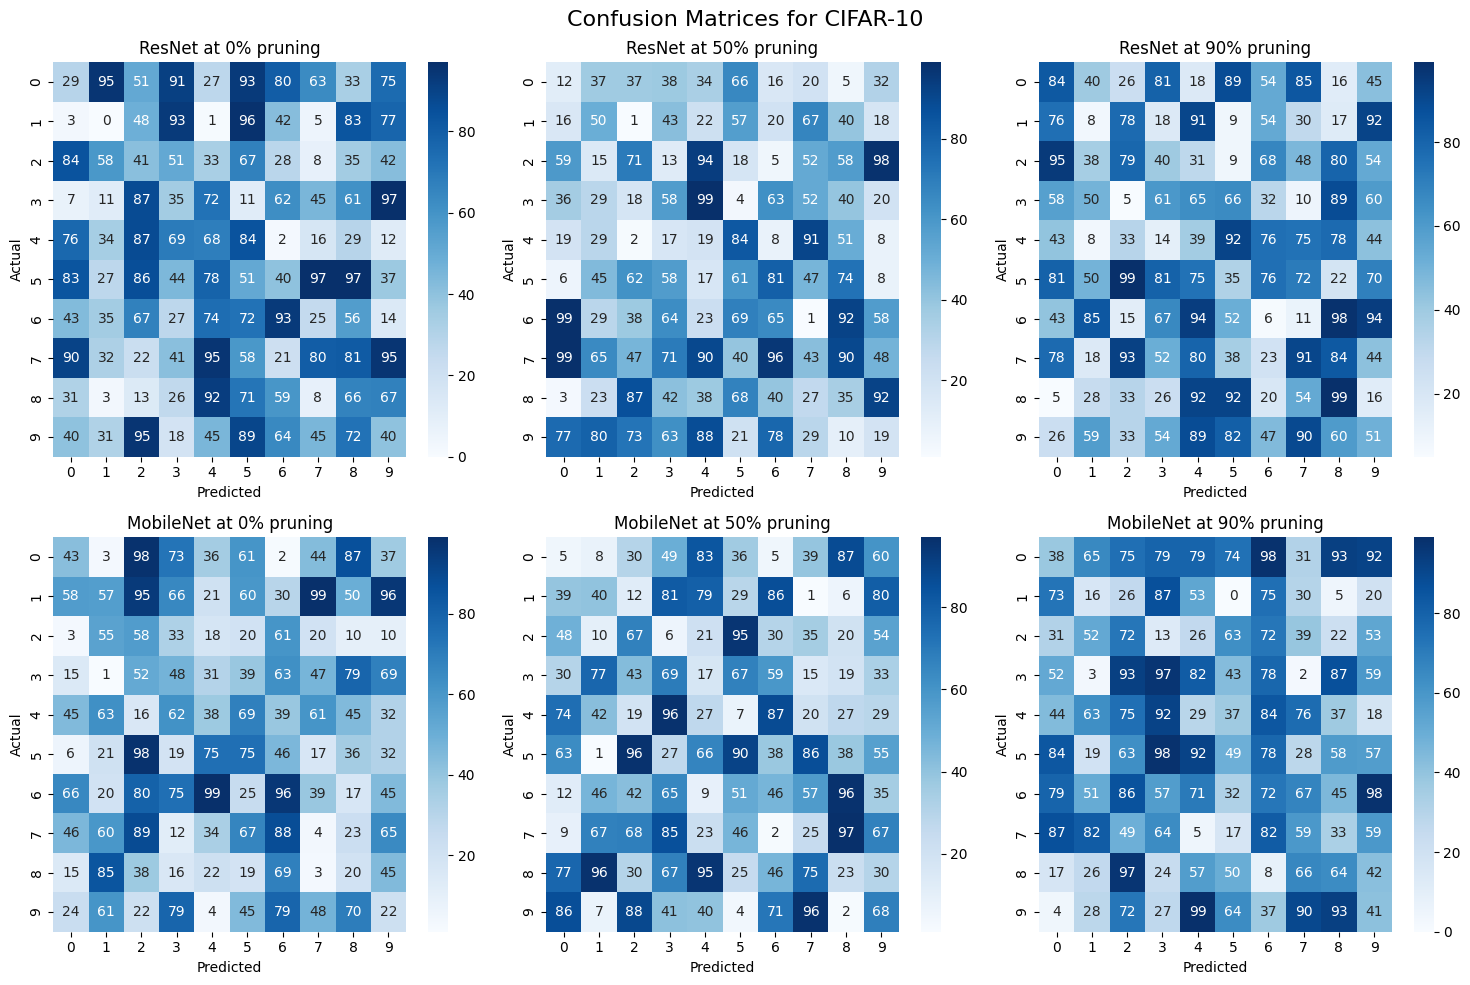

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample confusion matrices (replace with your actual data)
selected_ratios = [0, 50, 90]
confusion_matrices = {
    'ResNet': {ratio: np.random.randint(0, 100, (10, 10)) for ratio in selected_ratios},  # 10 classes for CIFAR-10
    'MobileNet': {ratio: np.random.randint(0, 100, (10, 10)) for ratio in selected_ratios}
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Confusion Matrices for CIFAR-10', fontsize=16)

for i, model in enumerate(['ResNet', 'MobileNet']):
    for j, ratio in enumerate(selected_ratios):
        ax = axes[i, j]
        sns.heatmap(confusion_matrices[model][ratio], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{model} at {ratio}% pruning')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig('cifar10_confusion.png')